In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Download NLTK stopwords
nltk.download('stopwords')

# Load the Twitter sentiment dataset
data = pd.read_csv('EcoPreprocessed.csv')
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,review,polarity,division
0,3870,able play youtube alexa,0.5000,positive
1,62,able recognize indian accent really well drop ...,0.2794,positive
2,487,absolute smart device amazon connect external ...,0.1827,positive
3,3204,absolutely amaze new member family control hom...,0.3682,positive
4,1265,absolutely amaze previously sceptical invest m...,0.2333,positive


In [2]:
data=data.drop(data.columns[[0,2]],axis=1)
data.columns =['text', 'sentiment']
data.head()

,text,sentiment
0,able play youtube alexa,positive
1,able recognize indian accent really well drop ...,positive
2,absolute smart device amazon connect external ...,positive
3,absolutely amaze new member family control hom...,positive
4,absolutely amaze previously sceptical invest m...,positive


In [3]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows 
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
data['sentiment']= label_encoder.fit_transform(data['sentiment'])
  
data['sentiment'].unique()

array([2, 1, 0])

In [4]:
# Drop rows with missing values
data.dropna(inplace=True)

# Preprocess the data
stop_words = set(stopwords.words('english'))

# Remove stopwords and perform lowercasing
data['Cleaned_Text'] = data['text'].apply(lambda x: ' '.join([word.lower() for word in str(x).split() if word.lower() not in stop_words]))

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['Cleaned_Text'], data['sentiment'], test_size=0.2, random_state=42)

# Convert text to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [5]:
# Train the Naive Bayes classifier
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vectorized, y_train)

# Predict on the test set
y_pred_NB = naive_bayes.predict(X_test_vectorized)

              precision    recall  f1-score   support

           0       0.82      0.25      0.38        93
           1       0.67      0.05      0.09       127
           2       0.76      0.99      0.86       597

    accuracy                           0.76       817
   macro avg       0.75      0.43      0.44       817
weighted avg       0.75      0.76      0.69       817



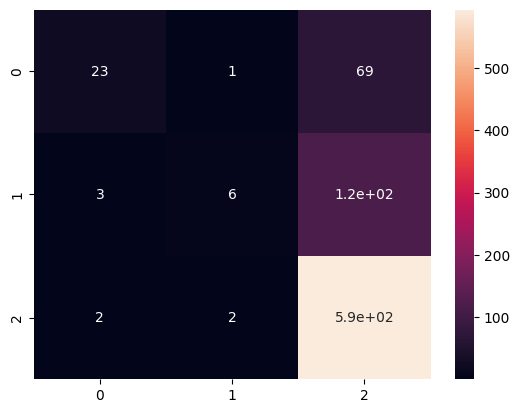

In [6]:
# Generate classification report
accuracy_NB=accuracy_score(y_test,y_pred_NB)
sns.heatmap(confusion_matrix(y_test,y_pred_NB),annot=True)
report_NB = classification_report(y_test, y_pred_NB)
print(report_NB)

              precision    recall  f1-score   support

           0       0.64      0.61      0.63        93
           1       0.80      0.83      0.82       127
           2       0.93      0.93      0.93       597

    accuracy                           0.88       817
   macro avg       0.79      0.79      0.79       817
weighted avg       0.88      0.88      0.88       817



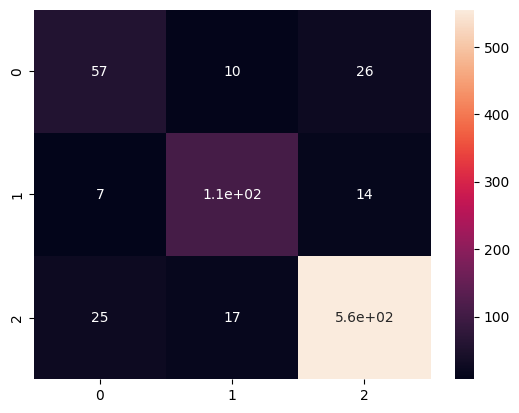

In [7]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()
clf.fit(X_train_vectorized,y_train)
y_pred_DT=clf.predict(X_test_vectorized)
report_DT = classification_report(y_test, y_pred_DT)
accuracy_DT=accuracy_score(y_test,y_pred_DT)
sns.heatmap(confusion_matrix(y_test,y_pred_DT),annot=True)
print(report_DT)

In [8]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [9]:
# Preprocess the dataset
sentences = data['text'].astype(str).values  # Convert to string
labels = data['sentiment'].values

# Split the dataset into training and testing sets
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Tokenize the sentences into words
train_words = [sentence.lower().split() for sentence in train_sentences]
test_words = [sentence.lower().split() for sentence in test_sentences]

In [10]:
# Train Word2Vec model
w2v_model = Word2Vec(train_words, vector_size=100, window=5, min_count=1)

# Get the vocabulary size
vocab_size = len(w2v_model.wv.index_to_key)

# Convert words to indices
train_sequences = [[w2v_model.wv.key_to_index[word] for word in sentence if word in w2v_model.wv.key_to_index] for sentence in train_words]
test_sequences = [[w2v_model.wv.key_to_index[word] for word in sentence if word in w2v_model.wv.key_to_index] for sentence in test_words]

# Pad sequences to have the same length
max_length = max(max(len(train_seq), len(test_seq)) for train_seq, test_seq in zip(train_sequences, test_sequences))
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [11]:
valid_indices = np.where(train_labels < 3)  # Filter out invalid labels
train_labels = train_labels[valid_indices]
train_sequences = train_sequences[valid_indices]

In [12]:
# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length, trainable=True))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes: negative, neutral, positive

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot vectors
train_labels_one_hot = to_categorical(train_labels, num_classes=3)
test_labels_one_hot = to_categorical(test_labels, num_classes=3)

# Train the model
model.fit(train_sequences, train_labels_one_hot, validation_data=(test_sequences, test_labels_one_hot), epochs=10, batch_size=256)

Epoch 1/10
13/13 [==============================] - 22s 766ms/step - loss: 0.9234 - accuracy: 0.7003 - val_loss: 0.8238 - val_accuracy: 0.7307
Epoch 2/10
13/13 [==============================] - 5s 415ms/step - loss: 0.7254 - accuracy: 0.7557 - val_loss: 0.7477 - val_accuracy: 0.7307
Epoch 3/10
13/13 [==============================] - 7s 556ms/step - loss: 0.6825 - accuracy: 0.7557 - val_loss: 0.7211 - val_accuracy: 0.7307
Epoch 4/10
13/13 [==============================] - 3s 224ms/step - loss: 0.6229 - accuracy: 0.7557 - val_loss: 0.6582 - val_accuracy: 0.7307
Epoch 5/10
13/13 [==============================] - 2s 170ms/step - loss: 0.5190 - accuracy: 0.7744 - val_loss: 0.5839 - val_accuracy: 0.7344
Epoch 6/10
13/13 [==============================] - 2s 168ms/step - loss: 0.3976 - accuracy: 0.8286 - val_loss: 0.5787 - val_accuracy: 0.7503
Epoch 7/10
13/13 [==============================] - 2s 137ms/step - loss: 0.3728 - accuracy: 0.8589 - val_loss: 0.5838 - val_accuracy: 0.7674
Epoch

In [13]:
y_hat_LSTM=model.predict(test_sequences)

26/26 [==============================] - 1s 8ms/step


In [14]:
y_hat_LSTM

array([[5.52756712e-02, 1.08842626e-02, 9.33840096e-01],
       [7.09327869e-04, 6.30332332e-04, 9.98660326e-01],
       [3.45241046e-04, 3.73547780e-04, 9.99281228e-01],
       ...,
       [8.70795548e-01, 1.08708486e-01, 2.04959586e-02],
       [1.05931330e-02, 1.65160745e-02, 9.72890794e-01],
       [2.54672676e-01, 5.93459606e-02, 6.85981333e-01]], dtype=float32)

In [15]:
y_pred_LSTM=[]
for i in range(len(y_hat_LSTM)):
    y_pred_LSTM.append(np.argmax(y_hat_LSTM[i]))

Accuracy: 0.7796817625458996
Classification Report:
              precision    recall  f1-score   support

    negative       0.45      0.56      0.50        93
     neutral       0.66      0.30      0.41       127
    positive       0.85      0.92      0.88       597

    accuracy                           0.78       817
   macro avg       0.65      0.59      0.60       817
weighted avg       0.77      0.78      0.76       817



<Axes: >

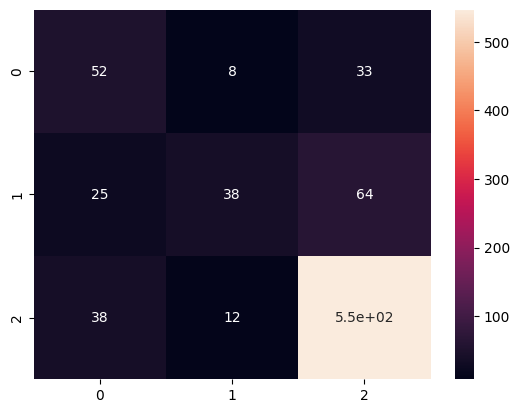

In [16]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy_BILSTM = accuracy_score(test_labels, y_pred_LSTM)
print('Accuracy:', accuracy_BILSTM)
# Generate classification report
class_labels = ['negative', 'neutral', 'positive']
report = classification_report(test_labels, y_pred_LSTM, target_names=class_labels)
print('Classification Report:')
print(report)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(test_labels, y_pred_LSTM)
sns.heatmap(confusion_mat,annot=True)

In [17]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import torch
from transformers import BertTokenizer, BertModel
import logging
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [19]:
# Load the Twitter sentiment dataset
df = pd.read_csv('EcoPreprocessed.csv')
df=df.drop(df.columns[[0,2]],axis=1)
df.columns =['text', 'sentiment']
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows 
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['sentiment']= label_encoder.fit_transform(df['sentiment'])
  
df['sentiment'].unique()

array([2, 1, 0])

In [20]:
token_var = ""
def token_text(text):
  marked_text = "[CLS] " + text + " [SEP]"

  # Tokenize our sentence with the BERT tokenizer.
  tokenized_text = tokenizer.tokenize(marked_text)

  # Print out the tokens.
 # print (tokenized_text)

  # Display the words with their indeces.
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  for tup in zip(tokenized_text, indexed_tokens):
      print('{:<12} {:>6,}'.format(tup[0], tup[1])) 
  segments_ids = [1] * len(tokenized_text)

  print (segments_ids)

  # Convert inputs to PyTorch tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  # Load pre-trained model (weights)
  model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
  model.eval()
  with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

  

In [21]:
token_text(df['text'][0])

[CLS]           101
able          2,583
play          2,377
youtube       7,858
alexa        24,969
[SEP]           102
[1, 1, 1, 1, 1, 1]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load and preprocess the dataset
dataset = ...  # Load your financial_news dataset here
sentences = df['text'].tolist()
sentiment_labels = df['sentiment'].tolist()

# Define the parameters
max_seq_length = 100  # Maximum sequence length
num_classes = 3  # Number of sentiment classes (positive, negative, neutral)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the sentences
input_ids = []
attention_masks = []

for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(
        sentences,
        add_special_tokens=True,
        max_length=max_seq_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)
sentiment_labels = tf.one_hot(sentiment_labels, depth=num_classes)

# Split the dataset into training and testing sets
split_ratio = 0.8  # 80% for training, 20% for testing
split_index = int(len(input_ids) * split_ratio)

train_input_ids = input_ids[:split_index]
train_attention_masks = attention_masks[:split_index]
train_labels = sentiment_labels[:split_index]
test_input_ids = input_ids[split_index:]
test_attention_masks = attention_masks[split_index:]
test_labels = sentiment_labels[split_index:]

# Load the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Freeze the BERT layers
bert_model.trainable = False

# Define the model architecture
input_ids_layer = Input(shape=(max_seq_length,), dtype=tf.int32)
attention_masks_layer = Input(shape=(max_seq_length,), dtype=tf.int32)
bert_output = bert_model(input_ids_layer, attention_mask=attention_masks_layer)[0]
relu_layer = Dense(units=32,activation='relu')(bert_output)
pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(relu_layer)
output_layer = Dense(units=num_classes, activation='softmax')(pooling_layer)

model = Model(inputs=[input_ids_layer, attention_masks_layer], outputs=output_layer)
model.summary()

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    [train_input_ids, train_attention_masks],
    train_labels,
    epochs=10,
    batch_size=32,
    validation_data=([test_input_ids, test_attention_masks], test_labels)
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['c

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [23]:
y_hat_BERT=model.predict([test_input_ids,test_attention_masks])

26/26 [==============================] - 9s 222ms/step


In [24]:
y_pred_BERT=[]
for i in range(len(y_hat_BERT)):
    y_pred_BERT.append(np.argmax(y_hat_BERT[i]))

In [25]:
test_labels=np.array(test_labels)

In [26]:
test_labels1=[]
for i in range(len(test_labels)):
    test_labels1.append(np.argmax(test_labels[i]))

Accuracy: 0.6854345165238678
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.00      0.00      0.00       116
           2       0.69      1.00      0.81       560

    accuracy                           0.69       817
   macro avg       0.23      0.33      0.27       817
weighted avg       0.47      0.69      0.56       817



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

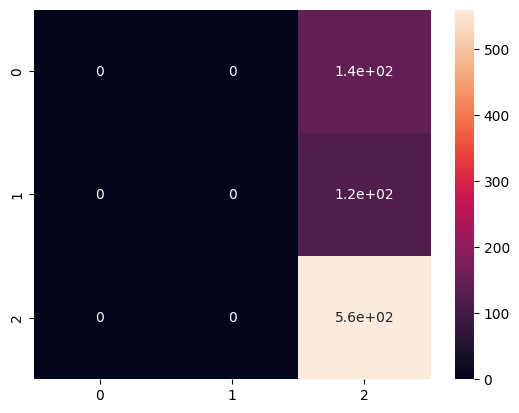

In [27]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy_BERT = accuracy_score(test_labels1, y_pred_BERT)
print('Accuracy:', accuracy_BERT)
# Generate classification report
class_labels = ['negative', 'neutral', 'positive']
report = classification_report(test_labels1, y_pred_BERT)
print('Classification Report:')
print(report)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(test_labels1, y_pred_BERT)
sns.heatmap(confusion_mat,annot=True)

In [28]:
metrics={'accuracy':[accuracy_NB,accuracy_DT,accuracy_BILSTM,accuracy_BERT]}
results=pd.DataFrame(metrics,index=['NAIVE BAYES','DECISION TREE','BILSTM','BERT'])
results


,accuracy
NAIVE BAYES,0.761322
DECISION TREE,0.878825
BILSTM,0.779682
BERT,0.685435


<Axes: >

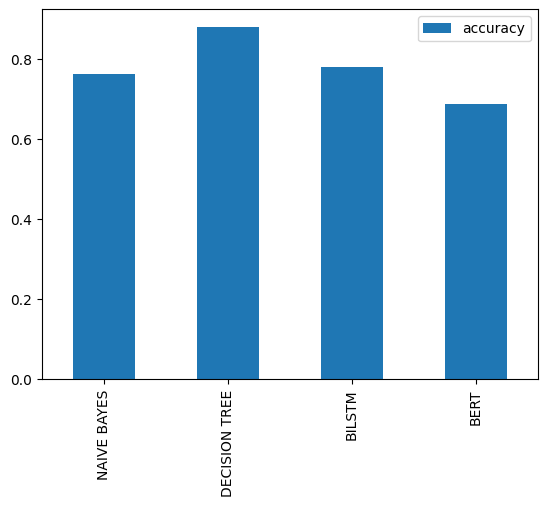

In [29]:
results.plot.bar()